### The One Notebook

This notebook begins at the survey response csv and translates this data into useful structures for analysis. Like Bilbo in the heart of the Misty Mountains, we must answer these riddles 3 if we ever hope to see the other side: Extracting the Data, Translating to Rand Values, Calculating Embedded Values and BenchMarks.

In [1]:
# Import Libraries

#Standard Library
import random
import json
import math
import os
import re

#3rd Party Libraries
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import PIL
import pandas as pd

#Warning Supression for Pandas Performance
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

#Formatting
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config InlineBackend.rc = {'figure.facecolor': 'w'}

### Loading Data

In [2]:
# Load Dataframes of the Response Data and the Decoding CSV of Img URLs

#Set CSV Names
QualtricsCSV = 'Responses100.csv'
RandomizedPairingsCSV = 'SampleColorPairs.csv'

#Create DataFrames
Q_df = pd.read_csv(QualtricsCSV)
R_df = pd.read_csv(RandomizedPairingsCSV) #reference dataframe

#Print Shape
print('Shape of Qualtrics Data:', Q_df.shape)
print('Shape of Reference Data:', R_df.shape)

Shape of Qualtrics Data: (104, 621)
Shape of Reference Data: (200, 5)


### Trimming Data 

In [3]:
# Due to Qualtrics formatting the data must be cut out of the group rank column
#Misc Columns to Drop
drop_columns = ['StartDate','ProlificID', 'EndDate', 'Status', 'IPAddress', 'Progress', 
                      'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
                      'RecipientLastName', 'RecipientFirstName', 'RecipientEmail', 'ExternalReference',
                      'LocationLatitude', 'LocationLongitude', 'DistributionChannel', 'UserLanguage', 
                      'EmbeddedData', 'Create New Field or Choose From Dropdown...', 'Q3']

#Cut rank columns per question
rank_cut = ['{}_Q1_0_1_RANK'.format(x) for x in range(1,201)]
rank_cut_2 = ['{}_Q1_0_2_RANK'.format(x) for x in range(1,201)] 
drop_columns.extend(rank_cut)
drop_columns.extend(rank_cut_2)

#Drop the Columns
Q_df = Q_df.drop(columns=drop_columns)

#Remove the pesky 2nd header row
Q_df = Q_df.iloc[2: , :]

#Finally defragmenting the DataFrame for Performance
ogQ_df = Q_df.copy()

#Print the Dataframe: check for 200 questions.
print('Trimmed Data frame shape: ', Q_df.shape, '\n')
print(Q_df)

"""From onward, you can refer to the original data via ogQ_df"""

Trimmed Data frame shape:  (102, 200) 

    1_Q1_0_GROUP 2_Q1_0_GROUP 3_Q1_0_GROUP 4_Q1_0_GROUP 5_Q1_0_GROUP  \
2              2          NaN          NaN          NaN          NaN   
3            NaN          NaN          NaN          NaN          NaN   
4            NaN          NaN          NaN          NaN          NaN   
5              1          NaN            2          NaN          NaN   
6            NaN          NaN          NaN          NaN          NaN   
..           ...          ...          ...          ...          ...   
99           NaN          NaN          NaN          NaN          NaN   
100            1          NaN          NaN          NaN          NaN   
101            1            2          NaN          NaN          NaN   
102          NaN          NaN            1          NaN          NaN   
103          NaN          NaN          NaN            1          NaN   

    6_Q1_0_GROUP 7_Q1_0_GROUP 8_Q1_0_GROUP 9_Q1_0_GROUP 10_Q1_0_GROUP  ...  \
2            NaN 

'From onward, you can refer to the original data via ogQ_df'

### Translate Group Number to Rand Index

In [4]:
# We will now translate the values that are not nan into the rand index
#  of the corresponding question.

#Lamba Function to retrieve Rand Indexes from reference csv
def get_maxrand_index(x, q):
    
    response = 0
    if isinstance(x, str): #If a string and not nan
        if x == '1': #if 1, give filename
            response = int(R_df['FileName'][q][:-4])
        elif x == '2': #if 2, give associated pairing filename
            response = int(R_df['RandFile'][q][:-4])   
        else:
            response = 0
            
    return response

def get_minrand_index(x, q):
    
    response = 0
    if isinstance(x, str): #If a string and not nan
        if x == '1': #if 1, give filename
            response = int(R_df['RandFile'][q][:-4]) 
        elif x == '2': #if 2, give associated pairing filename  
            response = int(R_df['FileName'][q][:-4])
        else:
            response = 0
            
    return response

#Running a loop that references R_df (reference_dataframe) for the index
for q in range(0,Q_df.shape[1]):
    Q_df['Similar_Q{}'.format(q+1)] = Q_df['{}_Q1_0_GROUP'.format(q+1)].apply(lambda x: get_maxrand_index(x, q))
    Q_df['Different_Q{}'.format(q+1)] = Q_df['{}_Q1_0_GROUP'.format(q+1)].apply(lambda x: get_minrand_index(x, q))

In [5]:
# Apologies for the massive errors, but the current version of pandas has an unresolved bug with
#  format based column selection being percieved as fragmentation. 
#  Hopefully a contributer changes that soon

#Let us relock onto the relevant portion of the dataframe.
RandQ_df = Q_df.iloc[:, 200:]
print(np.unique(RandQ_df['Similar_Q1'], return_counts=True))

"""One can reach this dataframe at any time using RandQ_df"""

(array([     0, 103355, 491072]), array([90, 10,  2]))


'One can reach this dataframe at any time using RandQ_df'

### DataFrame Reference Text

    The RandQ_df dataframe provides two columns per question:
    The Similar Column shows which image the participant selected as similar
    The Different Column shows which image the participant selected as different
    
    *The Difference column is a mirror of the first, for ease of deducing matched
        image pairs!
    
    To deduce the total number of votes one can sum the answers that
    are not 0 in either of the columns.
    
    We will now export this dataframe as the defacto data to be analyzed.

### Saving the DF to CSV

In [6]:
RandQ_df.to_csv('ResponseIndex.csv')

### Retrieving the BenchMark ID's & Calculating Embeddings

To retrieve the benchmarks from the random set we need to calculate the cnn/wavlet embeddings and look for embeddings >= 0.5. First we need to retrive the embedding data.

In [7]:
# Load the JzAzBz Array
jzazbz_array_npy = np.load('./jzazbz_array.npy')

#Defining Lists
img_names = []
colors = []
jzazbz_colors = []
rgb_colors = []
jz_all = []
az_all = []
bz_all = []

#Retrieve all sample files and place into an array of color lists
for file in os.listdir('./block_stimuli'):
    if not file.startswith('.'): #Prevents hidden files from being analyzed
        
        img_names.append(file)
        color = np.array([float(re.search('\[(.*?),', file).group(1)),
                          float(re.search(',(.*?),', file).group(1)),
                          float(re.search('0(.*?)\]', file.split(' ')[-1]).group(1))])
        
        #Conversion from 0-1 to 0-255
        colors.append(color*255.) 
        
        #Rounding into rgb color space, note this conversion may bias to ceiling RGB levels.
        rgb_colors.append([int(round(255.*color[0])), int(round(255.*color[1])), int(round(255.*color[2]))])
        
        #Appending rounded RGB to Jzazbz
        jzazbz_colors.append(jzazbz_array_npy[int(round(255.*color[0])), int(round(255.*color[1])), int(round(255.*color[2]))])
        
        #More appending
        jz_all.append(jzazbz_array_npy[int(round(255.*color[0])), int(round(255.*color[1])), int(round(255.*color[2]))][0])
        az_all.append(jzazbz_array_npy[int(round(255.*color[0])), int(round(255.*color[1])), int(round(255.*color[2]))][1])
        bz_all.append(jzazbz_array_npy[int(round(255.*color[0])), int(round(255.*color[1])), int(round(255.*color[2]))][2])

#Distribution Array, Square
dists = np.zeros((len(jzazbz_colors),len(jzazbz_colors)))

#RGB distribution array
rgb_dists = np.zeros((len(jzazbz_colors),len(jzazbz_colors)))

#Some form of files array
files1 = np.empty((len(jzazbz_colors),len(jzazbz_colors))).tolist()
files2 = np.empty((len(jzazbz_colors),len(jzazbz_colors))).tolist()

#Color difference pair arrays
colors1 = np.empty((len(jzazbz_colors),len(jzazbz_colors),3))
colors2 = np.empty((len(jzazbz_colors),len(jzazbz_colors),3))

#Place to save means and differences
jz_all_mean = np.zeros((len(jzazbz_colors),len(jzazbz_colors)))
jz_all_diff = np.zeros((len(jzazbz_colors),len(jzazbz_colors)))
az_all_mean = np.zeros((len(jzazbz_colors),len(jzazbz_colors)))
az_all_diff = np.zeros((len(jzazbz_colors),len(jzazbz_colors)))
bz_all_mean = np.zeros((len(jzazbz_colors),len(jzazbz_colors)))
bz_all_diff = np.zeros((len(jzazbz_colors),len(jzazbz_colors)))


for i, color1 in enumerate(jzazbz_colors):
    for j,color2 in enumerate(jzazbz_colors):
        
        #Calculating Color distances in Euclidean Space
        dists[i][j] = np.sqrt((color1[0]-color2[0])**2+(color1[1]-color2[1])**2+(color1[2]-color2[2])**2)
        
        #Euclidean distances of RGB space
        rgb_dists[i][j] = np.sqrt((rgb_colors[i][0]-rgb_colors[j][0])**2+(rgb_colors[i][1]-rgb_colors[j][1])**2+(rgb_colors[i][2]-rgb_colors[j][2])**2)
        
        files1[i][j] = img_names[i]
        files2[i][j] = img_names[j]
        
        colors1[i][j] = rgb_colors[i]
        colors2[i][j] = rgb_colors[j]
        
        jz_all_mean[i][j] = 0.5*(jz_all[i]+jz_all[j])
        jz_all_diff[i][j] = np.abs(jz_all[i]-jz_all[j])
        az_all_mean[i][j] = 0.5*(az_all[i]+az_all[j])
        az_all_diff[i][j] = np.abs(az_all[i]-az_all[j])
        bz_all_mean[i][j] = 0.5*(bz_all[i]+bz_all[j])
        bz_all_diff[i][j] = np.abs(bz_all[i]-bz_all[j])
        
#All distributions
dists = np.ravel(dists) 

#made from taking the distrubtions and subtraciting the means
minmax_dists = (dists-np.min(dists))/(np.max(dists)-np.min(dists))
rgb_dists = np.ravel(rgb_dists)
rgb_minmax_dists = (rgb_dists-np.min(rgb_dists))/(np.max(rgb_dists)-np.min(rgb_dists))


In [8]:
#JzAzBz Means
jz_all_mean = np.ravel(jz_all_mean)
minmax_jz_all_mean = (jz_all_mean-np.min(jz_all_mean))/(np.max(jz_all_mean)-np.min(jz_all_mean))

jz_all_diff = np.ravel(jz_all_diff)
minmax_jz_all_diff = (jz_all_diff-np.min(jz_all_diff))/(np.max(jz_all_diff)-np.min(jz_all_diff))

az_all_mean = np.ravel(az_all_mean)
minmax_az_all_mean = (az_all_mean-np.min(az_all_mean))/(np.max(az_all_mean)-np.min(az_all_mean))

az_all_diff = np.ravel(az_all_diff)
minmax_az_all_diff = (az_all_diff-np.min(az_all_diff))/(np.max(az_all_diff)-np.min(az_all_diff))

bz_all_mean = np.ravel(bz_all_mean)
minmax_bz_all_mean = (bz_all_mean-np.min(bz_all_mean))/(np.max(bz_all_mean)-np.min(bz_all_mean))

bz_all_diff = np.ravel(bz_all_diff)
minmax_bz_all_diff = (bz_all_diff-np.min(bz_all_diff))/(np.max(bz_all_diff)-np.min(bz_all_diff))

In [9]:
#Wavelet Embeddings Generation
wavelet_jzazbz = np.loadtxt('block_stimuli_coeffs_jzazbz.txt')
wavelet_grayscaled = np.loadtxt('block_stimuli_coeffs_grey.txt')
df = pd.read_csv('data_files_list.txt', header=None, sep='\r\n', engine='python') # sep='\n'
img_names_wavelet_order = []


for i in range(len(df.values)):
    img_names_wavelet_order.append(df.values[i])
    
wavelet_embeddings = []
wavelet_embeddings_grayscaled = []

for img in img_names:
    for i in range(len(img_names_wavelet_order)):
        #print(i, img_names_wavelet_order[i][0])
        if img == img_names_wavelet_order[i]:
            wavelet_embeddings.append(wavelet_jzazbz[i])
            wavelet_embeddings_grayscaled.append(wavelet_grayscaled[i])
        
wavelet_dists = np.zeros((len(wavelet_embeddings),len(wavelet_embeddings)))

for i,wavelet1 in enumerate(wavelet_embeddings):
    for j,wavelet2 in enumerate(wavelet_embeddings):
        wavelet_dists[i][j] = np.dot(wavelet1,wavelet2)/(np.sqrt(np.dot(wavelet1,wavelet1)*np.dot(wavelet2,wavelet2)))

        
wavelet_dists = np.ravel(wavelet_dists)
minmax_wavelet_dists = (wavelet_dists-np.min(wavelet_dists))/(np.max(wavelet_dists)-np.min(wavelet_dists))

wavelet_dists_grayscaled = np.zeros((len(wavelet_embeddings_grayscaled),len(wavelet_embeddings_grayscaled)))

for i,wavelet1 in enumerate(wavelet_embeddings_grayscaled):
    for j,wavelet2 in enumerate(wavelet_embeddings_grayscaled):
        wavelet_dists_grayscaled[i][j] = np.dot(wavelet1,wavelet2)/(np.sqrt(np.dot(wavelet1,wavelet1)*np.dot(wavelet2,wavelet2)))

wavelet_dists_grayscaled = np.ravel(wavelet_dists_grayscaled)
minmax_wavelet_dists_grayscaled = (wavelet_dists_grayscaled-np.min(wavelet_dists_grayscaled))/(np.max(wavelet_dists_grayscaled)-np.min(wavelet_dists_grayscaled))

In [10]:
#CNN Embeddings
with open('block_stimuli_resnet.json', 'r') as fp:
    cnn = json.load(fp)
    
cnn_embeddings = []

for name in img_names:
    cnn_embeddings.append(cnn[name[0:-4]])
    
cnn_dists = np.zeros((len(cnn_embeddings),len(cnn_embeddings)))

for i,cnn1 in enumerate(cnn_embeddings):
    for j,cnn2 in enumerate(cnn_embeddings):
        cnn_dists[i][j] = np.dot(cnn1,cnn2)/(np.sqrt(np.dot(cnn1,cnn1)*np.dot(cnn2,cnn2)))
        
cnn_dists = np.ravel(cnn_dists)
minmax_cnn_dists = (cnn_dists-np.min(cnn_dists))/(np.max(cnn_dists)-np.min(cnn_dists))

### Finding Benchmark IDs

In [11]:
# Using R_df we retrieve a list of rands. 

rand_column = R_df['FileName'].tolist()
rands = [int(i[:-4]) for i in rand_column]

print('Length of Rands: ', len(rands), '\n')
print(rands)

Length of Rands:  200 

[103355, 107450, 110268, 114352, 120151, 121958, 125657, 128148, 128391, 129473, 129981, 131932, 135230, 137337, 139182, 149503, 152617, 155576, 156542, 156730, 157164, 158823, 171829, 171836, 171890, 173416, 175203, 177247, 177789, 177804, 17955, 184779, 191335, 197775, 199041, 20056, 214176, 218126, 220884, 220984, 22671, 231915, 235167, 235362, 235796, 239931, 248710, 252764, 256840, 258795, 259178, 269536, 270936, 273538, 278167, 286103, 288790, 291999, 298356, 312252, 314877, 319030, 321879, 327069, 32711, 328947, 329365, 331236, 347449, 349457, 350605, 351279, 364167, 365838, 365871, 365890, 366326, 384681, 385777, 39081, 400573, 41090, 416880, 420571, 421909, 435564, 43585, 439792, 452366, 454351, 461243, 473254, 482690, 486232, 489492, 491072, 500186, 500328, 501108, 516349, 51663, 519332, 521430, 52528, 527035, 528178, 529036, 536226, 539439, 543176, 54886, 555839, 559042, 564685, 565894, 568550, 573665, 579879, 591723, 592673, 593128, 601661, 601863, 6

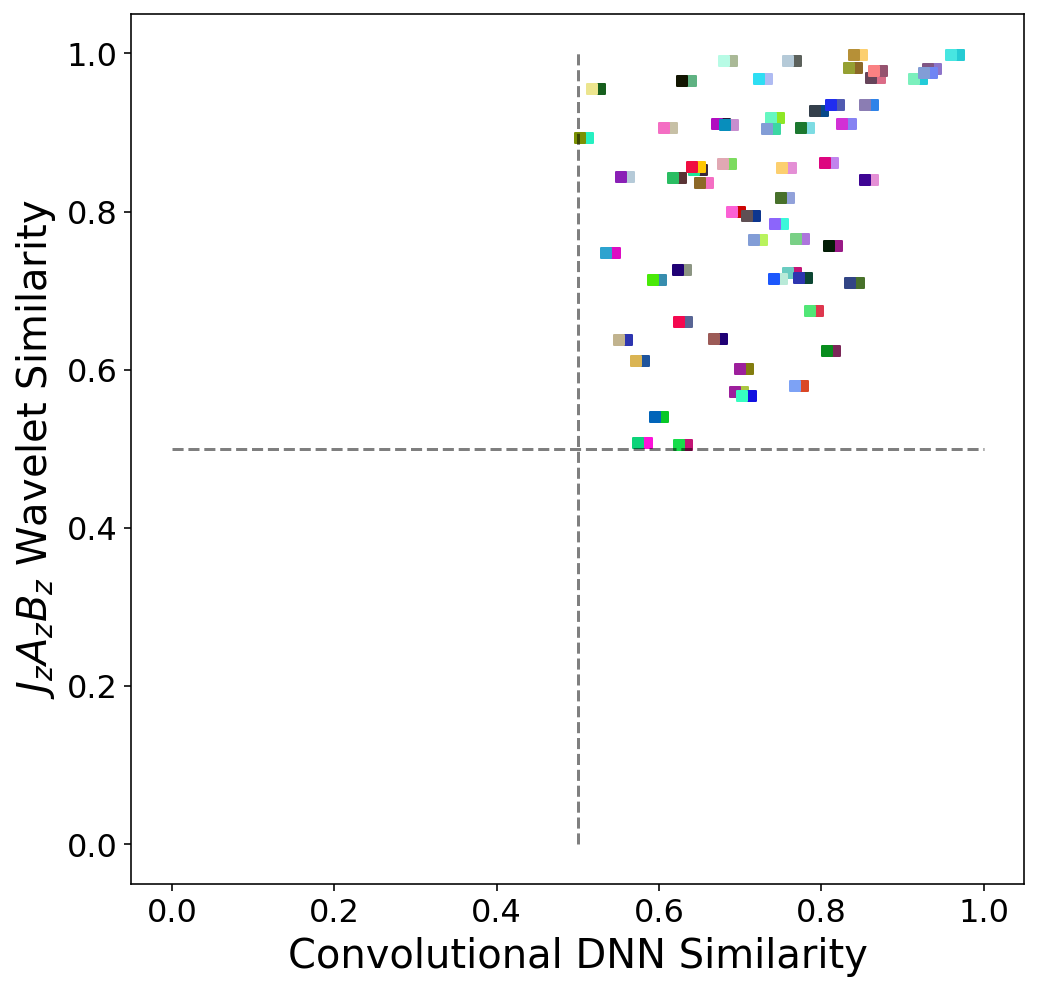

Length of Benchmark Set:  60
Benchmark Set:  [110268, 121958, 129981, 131932, 137337, 149503, 175203, 184779, 199041, 235796, 239931, 256840, 258795, 259178, 270936, 273538, 278167, 319030, 327069, 328947, 329365, 331236, 347449, 349457, 365838, 384681, 41090, 421909, 452366, 473254, 486232, 489492, 500186, 521430, 527035, 528178, 54886, 565894, 591723, 648143, 64820, 654811, 65725, 665987, 718315, 732180, 776997, 787201, 791743, 84654, 870910, 87498, 899159, 902648, 905778, 912756, 917040, 953277, 954698, 989436]


In [12]:
fig, ax = plt.subplots(figsize=(8,8))
benchmark_index = []

#Plot Pairs in 
for rand in rands:
    
    #ColorA
    a = minmax_cnn_dists[minmax_dists>0.][rand]
    b = minmax_wavelet_dists[minmax_dists>0.][rand]
    
    #ColorB
    c = -0.01+minmax_cnn_dists[minmax_dists>0.][rand]
    d = minmax_wavelet_dists[minmax_dists>0.][rand]
    
    color1 = np.array(colors1).reshape(1000000,3)[minmax_dists>0.][rand]/255.
    color2 = np.ravel(colors2).reshape(1000000,3)[minmax_dists>0.][rand]/255.
    
    #If CNN and Wavlet Embedding is > 0.5, then plot and add to benchmark index.
    if a > 0.5 and b > 0.5:
        ax.scatter(a,b, marker='s',s=30,alpha=1., color=color1)
        ax.scatter(c,d, marker='s',s=30,alpha=1., color=color2)
        
        benchmark_index.append(rand)
    
plt.plot(np.ones(10)*0.5,np.linspace(0.,1.,10),'k--',alpha=0.5)
plt.plot(np.linspace(0.,1.,10),np.ones(10)*0.5,'k--',alpha=0.5)

plt.xticks([0.,0.2,0.4,0.6,0.8,1.0],fontsize=16)
plt.yticks([0.,0.2,0.4,0.6,0.8,1.0],fontsize=16)

plt.xlabel(r'Convolutional DNN Similarity',fontsize=20)
plt.ylabel(r'$J_z A_z B_z$ Wavelet Similarity',fontsize=20)
plt.show()

print('Length of Benchmark Set: ', len(benchmark_index))
print('Benchmark Set: ', benchmark_index)

### Creating Embedding Dataframe & Mapping Embeddings

In [88]:
#Make Lists and apply all to the dataframe
cnn = []
wav = []
jzazbz = []
rgb = []
benchmark = []

# Retrieving Embeddings for every Rand Index Value
for rand in rands: 
    cnn_embed = minmax_cnn_dists[minmax_dists>0.][rand]
    wav_embed = minmax_wavelet_dists[minmax_dists>0.][rand]
    jzazbz_embed = minmax_jz_all_mean[minmax_dists>0.][rand]
    rgb_embed = rgb_minmax_dists[minmax_dists>0.][rand]
    
    bench = False
    if rand in benchmark_index:
        bench = True
        
    cnn.append(cnn_embed)
    wav.append(wav_embed)
    jzazbz.append(jzazbz_embed)
    rgb.append(rgb_embed)
    benchmark.append(bench)

In [89]:
#Getting Majority and Minority Votes for each pair from RandQ_df
vote_array = np.empty((200,4), dtype='int')

for q in range(0,200):
    
    #Sorted Array of Majority Voted Similar
    a = RandQ_df['Similar_Q{}'.format(q+1)].where(RandQ_df['Similar_Q{}'.format(q+1)]!=0).value_counts()
    
    #Sorted Array of Majority Voted Different (used to index in the case of 100% A votes.)
    b = RandQ_df['Different_Q{}'.format(q+1)].where(RandQ_df['Different_Q{}'.format(q+1)]!=0).value_counts()
    
    #total votes
    c = np.sum(a[:])
    
    #Array format: Index of majority similar, Votes, Index of Minority, Votes
    vote_array[q]= int(a.index[0]), a.iloc[0], b.index[0], (c-b.iloc[0])

print('Shape of vote array: ',vote_array.shape)
print(vote_array[:20])

Shape of vote array:  (200, 4)
[[103355     10 491072      2]
 [149503     16 107450      0]
 [110268      7  17955      5]
 [732180      6 114352      5]
 [120151     12 618992      1]
 [121958      6 568550      0]
 [349457      6 125657      2]
 [128148      4 791743      2]
 [128391      5 822352      3]
 [239931     12 129473      0]
 [129981     15 329365      0]
 [131932      7 889765      6]
 [764121     10 135230      6]
 [137337      8 385777      3]
 [912756     12 139182      2]
 [149503     15 858158      0]
 [288790      6 152617      1]
 [718315      3 155576      3]
 [416880      8 156542      4]
 [347449      8 156730      6]]


In [92]:

out = []
for pair in vote_array:
    major = int(np.where(rands == pair[0])[0])
    minor = int(np.where(rands == pair[2])[0])
    
    out.append([rands[major], pair[1], pair[2], pair[3], 
          cnn[major], cnn[minor], 
          wav[major], wav[minor], 
          jzazbz[major], jzazbz[minor],
          rgb[major], rgb[minor],
          benchmark[major], benchmark[minor]])
    
    '''
    print(rands[major], pair[1], pair[2], pair[3], 
          cnn[major], cnn[minor], 
          wav[major], wav[minor], 
          jzazbz[major], jzazbz[minor],
          rgb[major], rgb[minor],
          benchmark[major], benchmark[minor]
         )'''
    

In [93]:
# One Frame to rule them all, One Frame to find them, One Frame to bring them all, and in the notebook bind them
TheOneFrame = pd.DataFrame(out, columns = [
                            'RandSimilar',  'MajorityVote',
                            'RandDifferent', 'MinorityVote',
                            'MajorCNN', 'MinorCNN',
                            'MajorWavelet', 'MinorWavelet',
                            'MajorJzAzBz', 'MinorJzAzBz',
                            'MajorRGB', 'MinorRGB',
                            'MajorIsBenchmark','MinorIsBenchmark'
                           ]) 

print(TheOneFrame)
TheOneFrame.to_csv('TheOneFrame.csv')

     RandSimilar  MajorityVote  RandDifferent  MinorityVote  MajorCNN  \
0         103355            10         491072             2  0.442575   
1         149503            16         107450             0  0.727279   
2         110268             7          17955             5  0.710107   
3         732180             6         114352             5  0.632895   
4         120151            12         618992             1  0.285419   
..           ...           ...            ...           ...       ...   
195       969587             8         529036             6  0.412947   
196       139182             9         973324             6  0.666255   
197       978217             4         482690             2  0.294154   
198       873332             7         989436             4  0.554749   
199       521430            14         990198             0  0.969299   

     MinorCNN  MajorWavelet  MinorWavelet  MajorJzAzBz  MinorJzAzBz  MajorRGB  \
0    0.398159      0.651812      0.924303 